<a href="https://colab.research.google.com/github/KoMurase/movie_research_2/blob/master/research_ReadyPlayer1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

方針: TextCNNを用いて各スコアに対してクラス分類を行う <br>
(具体的な方法) <br>
レビュー（評価）文章に対するスコアを学習させる <br>
スコアは0.1刻みの離散値のためクラス分類を行う <br>
今回はスコアを四捨五入して整数にして行う <br> 
よって5クラスのスコアに対する各レビューのクラス分類とする

In [143]:
!pip install japanize-matplotlib
!apt-get -q -y install swig 
!apt-get install mecab
!apt-get install libmecab-dev
!apt-get install mecab-ipadic-utf8
!pip install mecab-python3
!pip install unidic-lite
#日本語フォントのインストール　（wordcloudなどで可視化するため）
!apt-get -y install fonts-ipafont-gothic

!pip install neologdn 
#半角を全角に変換
!pip install mojimoji

Reading package lists...
Building dependency tree...
Reading state information...
swig is already the newest version (3.0.12-1).
0 upgraded, 0 newly installed, 0 to remove and 11 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
mecab is already the newest version (0.996-5).
0 upgraded, 0 newly installed, 0 to remove and 11 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libmecab-dev is already the newest version (0.996-5).
0 upgraded, 0 newly installed, 0 to remove and 11 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
mecab-ipadic-utf8 is already the newest version (2.7.0-20070801+main-1).
0 upgraded, 0 newly installed, 0 to remove and 11 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-ipafont-gothic is already the newest version (00303

In [160]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline 

path = "/content/drive/My Drive/movie_research/review_csv/SF_data.csv"
data = pd.read_csv(path) 

data = data[data["title"] == "レディ・プレイヤー1|Ready Player One"]

In [161]:
non_score = data[data["score"] == '-']
data = data[data["score"] != '-']

#前処理

In [194]:
#数値カラムに変換する
def prepro(df, col):
  df = df.copy() 
  df[col] = df[col].astype(float)

  return df

data = prepro(data, "score")

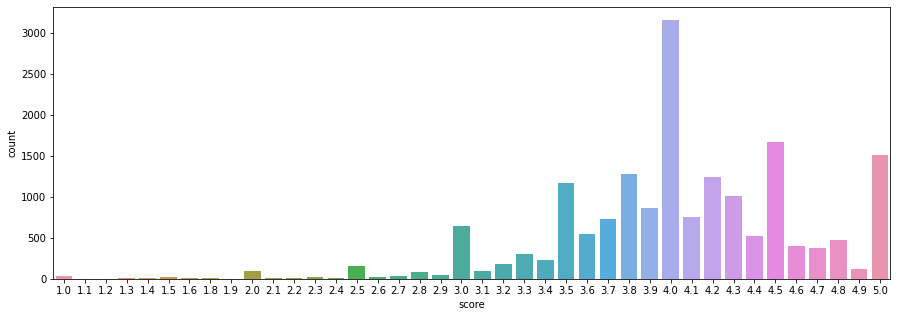

In [196]:
plt.figure(figsize=(15, 5))
sns.countplot(data["score"].sort_values())

In [197]:
#score(1,2,3,4,5)の5クラス分類にする
data["score"] = data["score"].round().astype(int)

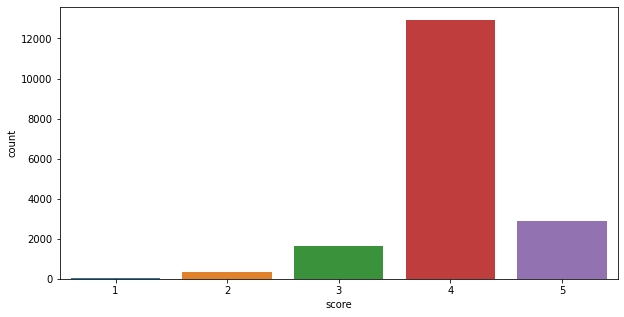

In [198]:
plt.figure(figsize=(10, 5))
sns.countplot(data["score"].sort_values())

レディ・プレイヤー1:
評価が全体的に高い傾向にあるデータを扱うことになりそう



In [207]:
data["time"] = pd.to_datetime(data["time"])

In [212]:
data["time"].sample(3)

413991   2018-06-26 00:01:00
423523   2020-03-11 14:31:00
414158   2018-06-16 10:24:00
Name: time, dtype: datetime64[ns]

(array([   0., 1000., 2000., ..., 4000., 5000., 6000.]),
 <a list of 7 Text major ticklabel objects>)

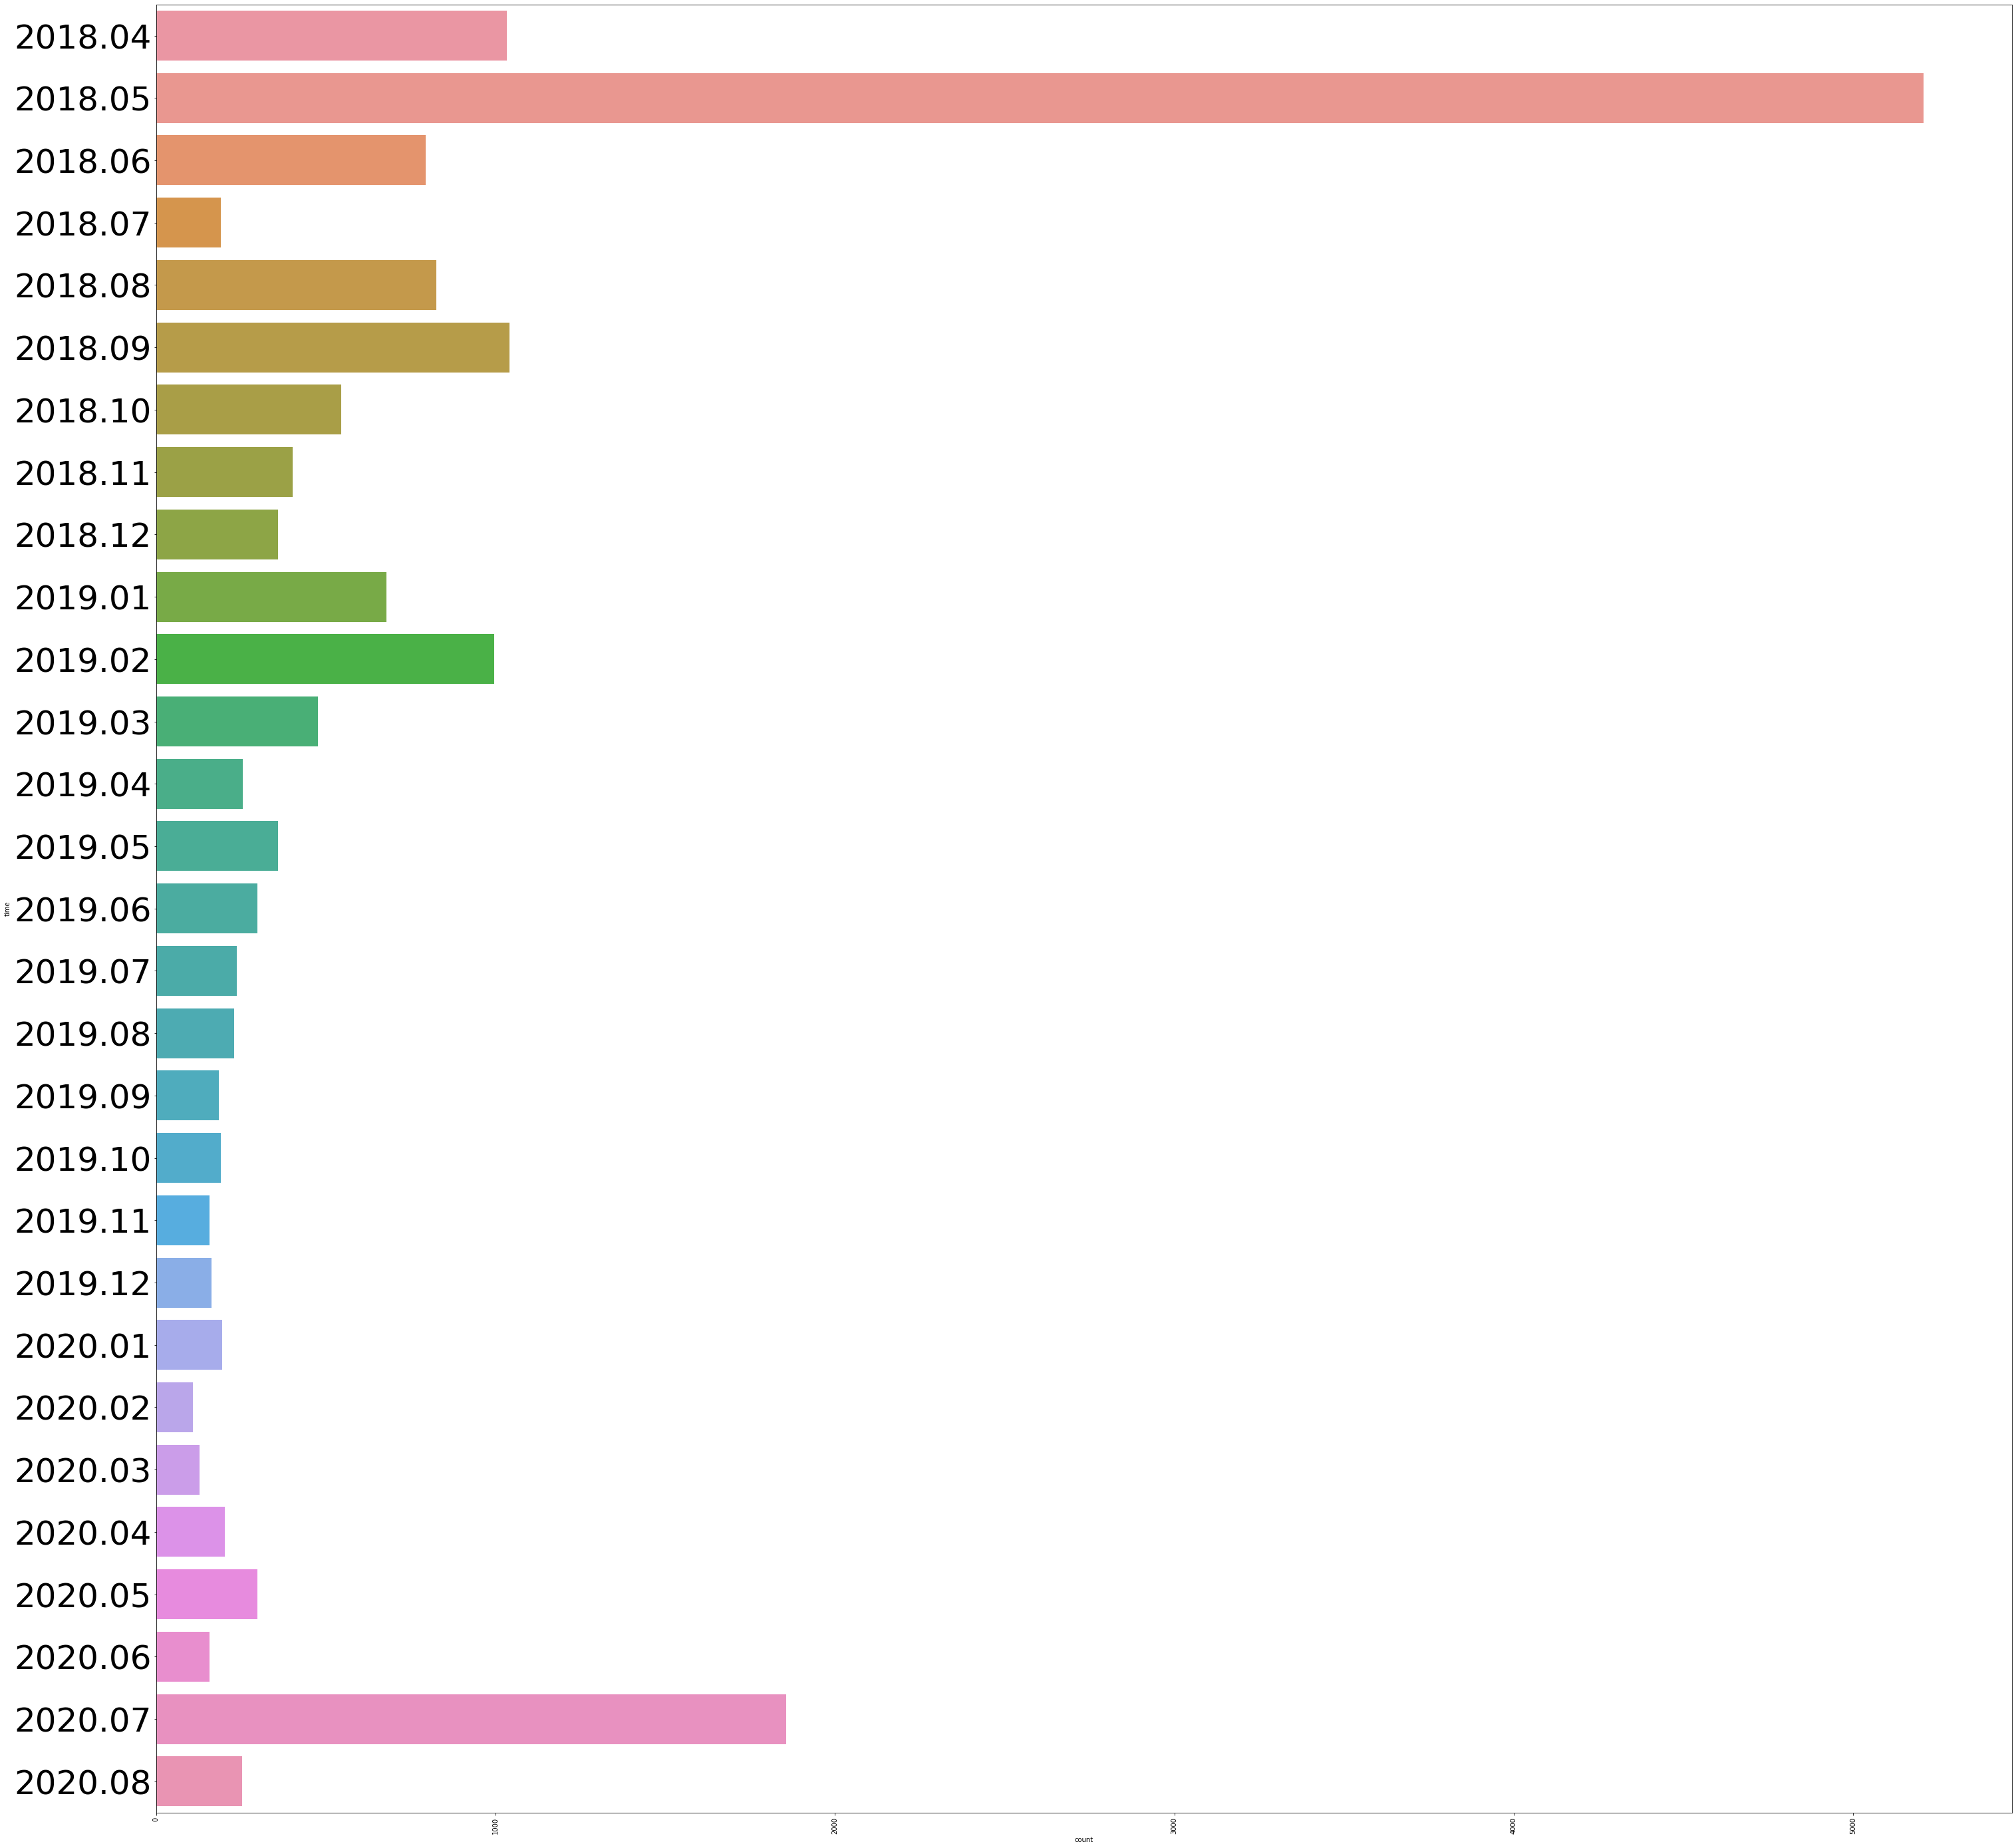

In [229]:
plt.figure(figsize=(50, 50))
sns.countplot(y=data["time"].dt.strftime('%Y.%m') )
plt.yticks(fontsize=50) #y軸のメモリサイズの拡大
plt.xticks(rotation=90) #x軸ラベルを縦に表示 

2020.7月に再度コメント数が伸びているのは金曜ロードショーで放映されたからと考えられそう <br> 
公開日が2018年4月20日のため，その翌月にコメント数が伸びている

In [206]:
import neologdn 
import mojimoji 
import re 

def text_preprocess(text):

  text = neologdn.normalize(text)
  #URLを除去する
  text = re.sub(
      r'(http|https)://([-\w]+\.)+[-\w]+(/[-\w./?%&=]*)?', 
      "",
      text)
  #全角から半角に
  text = mojimoji.zen_to_han(text) 
  #数字をすべて0に置換
  #text = re.sub(r'\d+', '0', text)
  
  #空白を除去
  text = re.sub(r' ','', text)
  text = re.sub(r'　','', text)
  # 【】の除去
  text = re.sub(r'[【】]', '', text)
  # （）の除去
  text = re.sub(r'[（）()]', '', text)
  # ［］の除去
  text = re.sub(r'[［］\[\]]', '', text)
  #アルファベットをの大文字を小文字に変換
  text = text.lower()
  #改行コードの除去
  text = text.replace('\n', '')

  return text 

In [163]:
data["review"] = data["review"].apply(text_preprocess) 

In [164]:
data["review"].sample(1).values

array(['最初から最後まで鳥肌が立ち涙がﾁｮﾁｮ切れるほどに面白かった…80年代を生きた人には更に感慨深かったのではないかと思うありとあらゆるｻﾌﾞｶﾙﾁｬｰが画面の端から端まで溢れている街､機械､車､ﾃﾞｼﾞﾀﾙの中の世界､全ての造形に心が揺り動かされﾜｸﾜｸが止まらず動悸しながら観終えたｵﾀｸのﾂﾎﾞを全部突いてくる'],
      dtype=object)

In [167]:
import MeCab 

def tokenize_mecab(sentence):
    """日本語の文を形態素の列に分割する関数

    :param sentence: str, 日本語の文
    :return tokenized_sentence: list of str, 形態素のリスト
    """
    tagger = MeCab.Tagger()
    node = tagger.parse(sentence)
    node = node.split("\n")
    tokenized_sentence = []
    for i in range(len(node)):
        feature = node[i].split("\t")
        if feature[0] == "EOS":
            # 文が終わったら終了
            break
        # 分割された形態素を追加
        tokenized_sentence.append(feature[0])
    return " ".join(tokenized_sentence)

In [168]:
data["review_tokenize"] = data["review"].apply(tokenize_mecab)

In [176]:
data["length"] = data["review_tokenize"].apply(lambda x: len(x.split(' ')))

In [177]:
np.set_printoptions(threshold=1)
print(data[data["length"]==3002]["review"].values )

['この映画が2018年4月に日本公開されて､ほぼ1年が経過する｡8090年代ﾎﾟｯﾌﾟｶﾙﾁｬｰへのｵﾏｰｼﾞｭに溢れたsf映画｡名匠ｽﾋﾟﾙﾊﾞｰｸﾞ監督の久しぶりの娯楽作品への本格的復帰に大いに興奮した｡80年代に青春を過ごし､ｽﾋﾟﾙﾊﾞｰｸﾞ映画で育った私の世代には超ｽﾄﾗｲｸな贈り物｡しかし一抹の不安も残るのだった…｡劇場公開時に鑑賞し､その後dvdも購入してｵﾏｰｼﾞｭを探して10回くらい見ただろうか?いい歳して1年近く､ｵﾏｰｼﾞｭ探すなよ…と言われそう｡何度見ても毎回面白いのだが､初見から感じる違和感がある｡私が歳を取ったせいもあるだろうが､ｽﾋﾟﾙﾊﾞｰｸﾞ監督のﾌｧﾝとして､その不安を言葉にして語っておきたい｡あ､韻を踏んだ…まずは娯楽作として大絶賛したい!速いﾍﾟｰｽで引き付けるｽﾄｰﾘｰﾃﾘﾝｸﾞは流石ｽﾋﾟﾙﾊﾞｰｸﾞ監督!時間の経過を忘れさせる｡まるでかつての少年ｼﾞｬﾝﾌﾟのｽﾛｰｶﾞﾝ｢友情､努力､勝利｣をそのまま実現し､ｶﾀﾙｼｽを感じる物語構成｡冴えない主人公が仲間と共に協力して､弱点を補いあい悪に立ち向かう､まるで劇場版ﾄﾞﾗえもんの如し!著作権料が心配になるほどの溢れるﾎﾟｯﾌﾟｶﾙﾁｬｰへのｵﾏｰｼﾞｭはここでは全て挙げられないが､要所に日本産のｷｬﾗｸﾀｰが出ているのが､日本人としてはとても嬉しい😊｡ｵｼﾞさんとしてはﾒｶｺﾞｼﾞﾗとｶﾞﾝﾀﾞﾑがﾊﾘｳｯﾄﾞ映画のｸﾗｲﾏｯｸｽで闘うなんて感涙ﾓﾉ｡観客に童心に返って映画を楽しんでもらうというｽﾋﾟﾙﾊﾞｰｸﾞ監督の狙いは大成功している!どうしても虚構のﾓﾉと感じてしまうcgも､描かれる世界がvr世界なので､私のようなcg嫌いのｵｼﾞさんでも現実じゃないからと割り切って見ることが出来る｡ｵﾏｰｼﾞｭついでに言うと｢sfとは新しいﾋﾞﾝにいれた古いﾌﾞﾄﾞｳ酒なのさ｣という｢ｺﾌﾞﾗ｣の作者､寺沢武一の言葉を思い出した｡ｷｬｯﾁｺﾋﾟｰの｢最高の､初体験｣はｵｼﾞさん世代のvr体験のことを､産まれた時からｹﾞｰﾑを空気のように接してきた若い世代にはｽﾋﾟﾙﾊﾞｰｸﾞ印のｽﾄｰﾘｰを初体験出来るﾀﾞﾌﾞﾙﾐｰﾆﾝｸﾞがある!初見の感想は､大興奮!満腹!ｽﾀﾝﾃﾞｨﾝｸﾞｵﾍﾞｰｼｮﾝ!すっかり少年に戻ってしまい､僕らのｽﾋﾟﾙﾊﾞｰｸﾞが帰って来た!と心の中で叫んだ｡しかし

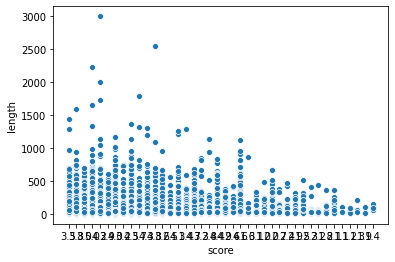

In [178]:
import seaborn as sns 
sns.scatterplot(x=data["score"],y=data["length"])

In [179]:
data[data["length"]==3002]

,title,name,time,review,score,URL,review_tokenize,length
427289,レディ・プレイヤー1|Ready Player One,yoshiの感想・評価,2019/02/16 21:47,この映画が2018年4月に日本公開されて､ほぼ1年が経過する｡8090年代ﾎﾟｯﾌﾟｶﾙﾁｬ...,4.2,https://filmarks.com//movies/63747?page=649,この 映画 が 2018 年 4 月 に 日本 公開 さ れ て ､ ほぼ 1 年 が 経過...,3002


#TextCNNを用いてクラス分類を行う

##辞書の構築

In [201]:
class Vocab(object):
  def __init__(self, word2id={}):
    self.word2id = dict(word2id)
    self.id2word = {v: k for k, v in self.word2id.items()}
  
  def build_vocab(self, sentences, min_count=1):
    """
    コーパスから語彙の辞書を構築するメソッド

    :param sentences: list of list of str, コーパス
    :param min_count: int, 辞書に含める単語の最小出現回数
    """
    word_counter = {}
    for sentence in sentences:
      for word in sentence:
        # dict.get(key, 0)はdictにdict[key],なければ0を返す
        word_counter[word] = word_counter.get(word, 0) + 1
    
    #min_count回以上出現する単語を加える
    for word, count in sorted(word_counter.items(), key=lambda x: -x[1]):
      if count < min_count : 
        break 
      _id = len(self.word2id)
      self.word2id.setdefault(word, _id)
      self.id2word[_id] = word 
    
    #語彙に含まれる単語の出現回数を保持する
    #self.raw_vocab = {w: word_counter[w] for w in self.word2id.keys() if w in word_counter }


In [202]:
# 特殊なトークンは事前に定義しておく
PAD_TOKEN = '<PAD>'  # バッチ処理の際に、短い系列の末尾を埋めるために使う （Padding）
BOS_TOKEN = '<S>'  # 系列の始まりを表す （Beggining of sentence）
EOS_TOKEN = '</S>'  # 系列の終わりを表す （End of sentence）
UNK_TOKEN = '<UNK>'  # 語彙に存在しない単語を表す （Unknown）
PAD = 0
BOS = 1
EOS = 2
UNK = 3

MIN_COUNT = 1  # 語彙に含める単語の最低出現回数

# 単語をIDに変換する辞書の初期値を設定
word2id = {
    PAD_TOKEN: PAD,
    BOS_TOKEN: BOS,
    EOS_TOKEN: EOS,
    UNK_TOKEN: UNK,
    }

vocab = Vocab(word2id=word2id)
vocab.build_vocab(data["review_tokenize"].values.tolist(), min_count=MIN_COUNT)
print("語彙数:", len(vocab.word2id))

語彙数: 3255


##単語のID化

In [203]:
def sentence_to_ids(vocab, sen):
  """
  単語のリストをIDのリストに変換する関数
  :param vocab: class Vocab object
  :param sen : list of str, 文を分かち書きして得られた単語のリスト
  """
  #辞書にない言葉にUNKを割り当てる
  out = [vocab.word2id.get(word, UNK) for word in sen ]
  return out 

#日本語のテキストを単語IDに変換する
id_text = [sentence_to_ids(vocab, sen) for sen in data["review_tokenize"].values.tolist()]

In [204]:
print(data["review_tokenize"].values.tolist()[1])
print(id_text[1])

ﾃﾚﾋﾞ で 観 まし た ! 色んな 映画 や 昔 の 音楽 を ､ 彷彿 と さ せる よう な 新しく て 懐かしい 映画 ｡ 家族 と これ は あれ だ ね ､ 昔 はやっ た 音楽 だ ね って 話し ながら 観る の が 楽しかっ た です ｡
[69, 99, 70, 8, 4, 16, 4, 75, 4, 32, 13, 4, 6, 4, 29, 4, 199, 31, 9, 4, 40, 43, 4, 59, 4, 474, 4, 5, 4, 220, 67, 4, 38, 4, 17, 4, 1102, 1121, 4, 15, 4, 61, 4, 111, 21, 4, 58, 26, 4, 9, 4, 282, 13, 30, 4, 10, 4, 403, 18, 13, 7, 4, 40, 43, 4, 14, 4, 472, 909, 4, 15, 4, 36, 28, 4, 23, 4, 42, 28, 4, 33, 4, 120, 4, 17, 4, 474, 4, 23, 59, 11, 4, 6, 4, 220, 67, 4, 33, 4, 120, 4, 11, 10, 4, 204, 13, 4, 9, 19, 27, 4, 75, 21, 4, 5, 4, 19, 4, 67, 13, 18, 11, 4, 6, 4, 16, 34, 4, 14]


#DataLoaderの定義

In [ ]:
class DataLoader(object):
  def __init__(self, src_insts, tgt_insts, batch_size, shuffle=True):
    """
    :param src_insts: list, 入力言語の文章のリスト (単語IDのリスト)
    :param tgt_insts: list, 出力言語の文章のリスト (単語IDのリスト)
    :param batch_size: int, バッチサイズ
    :param shuffle: bool, サンプルをシャッフルするかどうか
    """
    self.data = list(zip(src_insts, tgt_insts))
    self.batch_size = batch_size 
    self.shuffle = shuffle 
    self.start_index = 0 
    self.reset() 

  def reset(self):
    if self.shuffle:
      self.data = shuffle(self.data, random_state=random_state)
    self.start_index = 0 
  def __iter__(self):
    return self 
  def __next__(self):

    def preprocess_seq(seqs):
      # パディング
      max_length = max([len(s) for s in seqs])
      data = [s + [PAD] * (max_length - len(s)) for s in seqs]
      # 単語の位置を表現するベクトルの作成
      positions = [[pos+1 if w != PAD else 0 for pos, w in enumerate(seq)] for seq in data ]
      #テンソルに変換
      data_tensor = torch.tensor(data, dtype=torch.long, device)
      position_tensor = torch.tensor(positions, dtype=torch.long, device=device)
      return data_tensor, position_tensor